In [160]:
import pandas as pd
import matplotlib.pyplot as plt 

In [4]:
RESULTS_FOLDER = "../results/"

In [5]:
FILENAME = "birch--triangle-100-3-random"

In [140]:
def parseNonHeuristic(line, columns):
    # drop the brackets and "non-heuristic," at the start
    line = line[15:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseHeuristic(line, columns):
    # drop the brackets
    line = line[11:-1]
    result = [element.lstrip() for element in line.split(",")] # remove whitespaces
    df = pd.DataFrame([result], columns=columns)
    return df

def parseRunResult(result, nonHeuristicDf, heuristicDf):
    line = line[1:-1]
    runner = result[0].split(":")[0]
    parseNonHeuristic(result[1])
    print("Runner", runner)
    
    return

def readResultsFile(filename):
    nonHeuristicDf = pd.DataFrame(columns=['runtime-non','mse-non','iterations-non'])
    heuristicDf = pd.DataFrame(columns=['runtime-heur','mse-achieved','mse-heur','iterations-heur','pim','stagnation'])

    with open(RESULTS_FOLDER + filename, 'r') as filehandle:
        currentRunner = None
        for line in filehandle:
            line = line[:-1]
            if ":" in line:
                currentRunner = line.split(":")[0]
            elif line.startswith("non-heuristic"):
                parsedLine = parseNonHeuristic(line, list(nonHeuristicDf.columns)),  
                nonHeuristicDf = nonHeuristicDf.append(parsedLine,ignore_index = True)
            elif line.startswith("heuristic"):
                parsedLine = parseHeuristic(line, list(heuristicDf.columns)),  
                heuristicDf = heuristicDf.append(parsedLine, ignore_index = True)
            else:
                raise Exception("Unknown line:", line)
    heuristicDf['runtime-heur'] =  heuristicDf['runtime-heur'].astype(float, errors = 'raise')
    heuristicDf['mse-achieved'] = heuristicDf['mse-achieved'].map(lambda x: x=="True")
    heuristicDf['mse-achieved'] =  heuristicDf['mse-achieved'].astype('bool')
    heuristicDf['stagnation'] = heuristicDf['stagnation'].map(lambda x: x=="True")
    heuristicDf['stagnation'] =  heuristicDf['stagnation'].astype(bool)
    nonHeuristicDf['runtime-non'] =  nonHeuristicDf['runtime-non'].astype(float, errors = 'raise')


    return nonHeuristicDf, heuristicDf

nonHeuristicDf, heuristicDf = readResultsFile(FILENAME)

In [143]:
results = nonHeuristicDf.merge(heuristicDf, left_index=True, right_index=True)
results

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
0,70.949558,57257310862133.82,4,50.593111,True,52892515391502.8,5,-0.11,False
1,141.071011,70256727074516.57,8,63.667108,True,63453544934926.98,2,-0.11,False
2,143.943314,62378940421130.72,5,49.396885,True,54204110974157.61,2,-0.11,False
3,114.600619,46213227262537.03,6,229.972948,True,46083072645907.2,45,-0.11,False
4,110.714106,52715945287198.62,5,332.268301,False,57445262833035.555,69,-0.11,True
5,111.191464,54316697541489.47,5,53.391401,True,52771505502711.92,3,-0.11,False
6,95.328445,51683570334092.91,4,65.556550,True,50544166553643.414,6,-0.11,False
7,99.755567,74053181976337.31,4,54.703756,True,58428950627069.375,1,-0.11,False
8,147.628589,59734425885134.234,6,51.509545,True,55890334101616.56,3,-0.11,False
9,159.461512,48156640906051.43,7,193.193671,True,48053252078566.04,26,-0.11,False


# Calculate average speedup

In [145]:
speedupRelevant = results[results.stagnation == False]
speedupRelevant

,runtime-non,mse-non,iterations-non,runtime-heur,mse-achieved,mse-heur,iterations-heur,pim,stagnation
0,70.949558,57257310862133.82,4,50.593111,True,52892515391502.8,5,-0.11,False
1,141.071011,70256727074516.57,8,63.667108,True,63453544934926.98,2,-0.11,False
2,143.943314,62378940421130.72,5,49.396885,True,54204110974157.61,2,-0.11,False
3,114.600619,46213227262537.03,6,229.972948,True,46083072645907.2,45,-0.11,False
5,111.191464,54316697541489.47,5,53.391401,True,52771505502711.92,3,-0.11,False
6,95.328445,51683570334092.91,4,65.556550,True,50544166553643.414,6,-0.11,False
7,99.755567,74053181976337.31,4,54.703756,True,58428950627069.375,1,-0.11,False
8,147.628589,59734425885134.234,6,51.509545,True,55890334101616.56,3,-0.11,False
9,159.461512,48156640906051.43,7,193.193671,True,48053252078566.04,26,-0.11,False


In [156]:
# speedup of the heuristic method
speedupRelevant['runtime-non'].sum()/speedupRelevant['runtime-heur'].sum()

1.3349139606065343

In [155]:
# % stagnated
len(results[results.stagnation == True])/len(results)

0.1

(array([1., 0., 0., 1., 0., 0., 2., 1., 1., 3.]),
 array([-115.37232876,  -94.2231915 ,  -73.07405424,  -51.92491698,
         -30.77577972,   -9.62664247,   11.52249479,   32.67163205,
          53.82076931,   74.96990657,   96.11904383]),
 <a list of 10 Patch objects>)

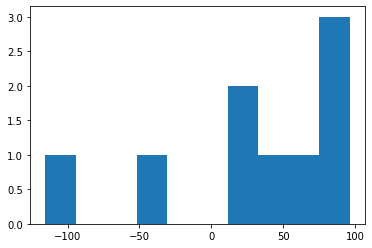

In [161]:
speedups = speedupRelevant['runtime-non'] - speedupRelevant['runtime-heur']
plt.hist(speedups)